In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cpu device


Random Color:


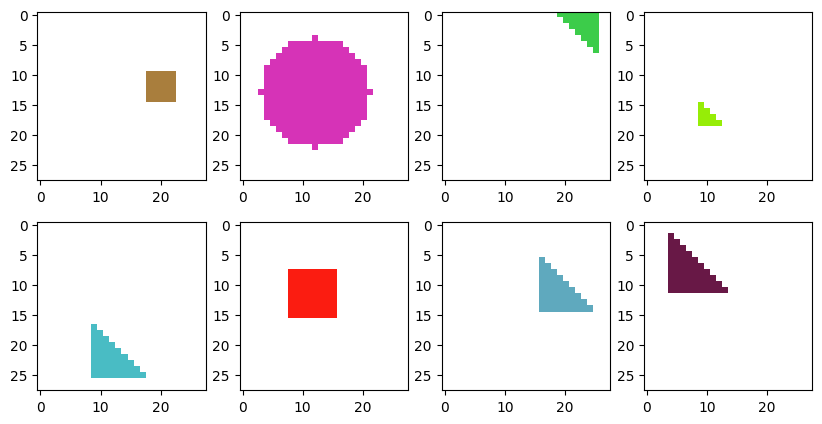

Fixed Color:


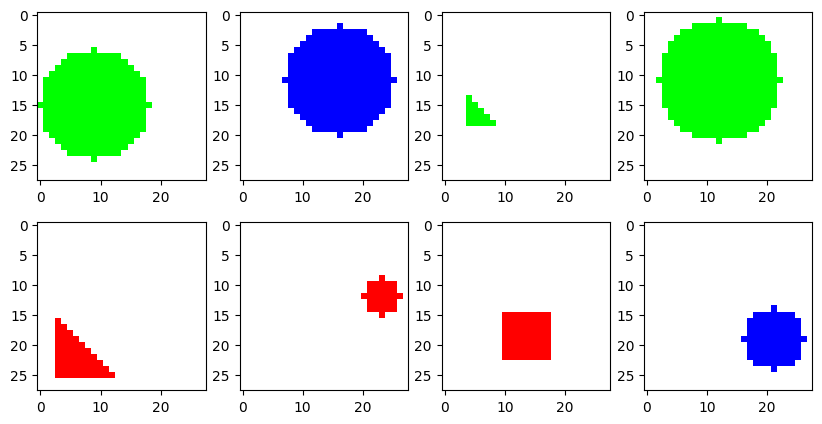

In [2]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=1000, image_size=(28, 28), random_color=True, color_list=None):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color
        self.color_list = color_list
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        image = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        return image_tensor
    
    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background
        
        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2.5)

        if shape == 'square':
            image = self.draw_square(image, size, color)
        elif shape=='circle':
            image = self.draw_circle(image, size, color)
        else:
            image = self.draw_triangle(image, size, color)
            
        return image
    
    def choose_color(self):
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            #return np.random.choice(self.color_list)
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            #return one of the three colors
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b

    
    def draw_square(self, image, size, color):
        x = np.random.randint(0, self.image_size[1] - size)
        y = np.random.randint(0, self.image_size[0] - size)
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, size, color):
        x = np.random.randint(0, self.image_size[1] - size)
        y = np.random.randint(0, self.image_size[0] - size)
        image[y:y+size, x:x+size] = color
        
        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image
          
    def draw_circle(self, image, radius, color):
        x = np.random.randint(radius, self.image_size[1] - radius)
        y = np.random.randint(radius, self.image_size[0] - radius)
        
        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

dataset_fixed_color = GeometricFiguresDataset(random_color=False, color_list=[[255, 0, 0], [0, 255, 0], [0, 0, 255]])
dataloader_fixed_color = torch.utils.data.DataLoader(dataset_fixed_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch

# Visualize some samples with fixed color
print("Fixed Color:")
for batch in dataloader_fixed_color:
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


In [3]:
batch_size = 32

dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=batch_size, shuffle=True)


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(8*7*7, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 8*7*7)
        self.conv2 = nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv1 = nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 8, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x
    

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(autoencoder, data, epochs=10, lr = 1e-3):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    for epoch in range(epochs):
        loss = 0
        for x in data:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss += loss.item()
        print(f" Epoch {epoch+1} -> Loss: {loss/len(data)}")
        
    return autoencoder

In [9]:
autoencoder = Autoencoder(latent_dims=10).to(device)

autoencoder = train(autoencoder, dataloader_random_color, epochs=250, lr = 1e-3)

 Epoch 1 -> Loss: 199.8564910888672
 Epoch 2 -> Loss: 53.718502044677734
 Epoch 3 -> Loss: 19.433486938476562
 Epoch 4 -> Loss: 59.845924377441406
 Epoch 5 -> Loss: 38.6171875
 Epoch 6 -> Loss: 25.48089599609375
 Epoch 7 -> Loss: 43.57190704345703
 Epoch 8 -> Loss: 30.39898681640625
 Epoch 9 -> Loss: 51.49691390991211
 Epoch 10 -> Loss: 33.19247817993164
 Epoch 11 -> Loss: 39.98844528198242
 Epoch 12 -> Loss: 15.814230918884277
 Epoch 13 -> Loss: 24.193405151367188
 Epoch 14 -> Loss: 11.211433410644531
 Epoch 15 -> Loss: 37.88918685913086
 Epoch 16 -> Loss: 12.127495765686035
 Epoch 17 -> Loss: 18.766605377197266
 Epoch 18 -> Loss: 23.685144424438477
 Epoch 19 -> Loss: 23.112573623657227
 Epoch 20 -> Loss: 14.798261642456055
 Epoch 21 -> Loss: 26.599790573120117
 Epoch 22 -> Loss: 16.00066375732422
 Epoch 23 -> Loss: 26.017545700073242
 Epoch 24 -> Loss: 9.435575485229492
 Epoch 25 -> Loss: 10.272649765014648
 Epoch 26 -> Loss: 21.784442901611328
 Epoch 27 -> Loss: 21.45855140686035
 E

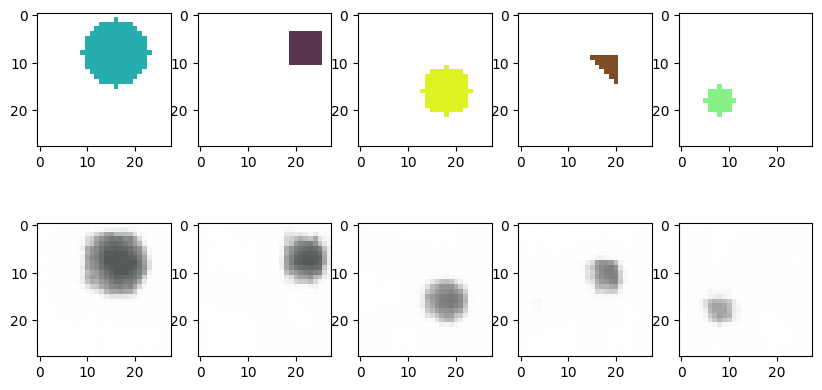

In [10]:
vis_batch = next(iter(dataloader_random_color))
vis_batch = vis_batch.to(device)

vis_recon = autoencoder(vis_batch)[0:5]

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(vis_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(vis_recon[i].permute(1, 2, 0).cpu().detach().numpy())